In [2]:
import re
import json

import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np

import seaborn as sns

/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kshitij/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

In [3]:
with open("../data/dev.json") as json_file:
    data = json.load(json_file)

In [4]:
print(data[0]['data']['text'])

PETITIONER:
THE COMMISSIONER OF INCOME-TAXNEW DELHI

Vs.

RESPONDENT:
M/s. CHUNI LAL MOONGA RAM

DATE OF JUDGMENT:
05/05/1961

BENCH:
DAS, S.K.
BENCH:
DAS, S.K.
HIDAYATULLAH, M.
SHAH, J.C.

CITATION:            1962 SCR (2) 823
 1962 AIR 1272

ACT:
Excess Profits Tax-Income-Assesseecarrying on business in
taxable territory-Losses incurred in transactionsin non-
taxable territory-If allowable in computing income-Excess
Profits Tax Act, 1940 (15 of 1940), s. 5.

HEADNOTE:
During the assessment year 1946-47, the assessee was
carrying on speculative business in bullion at Delhi. It
entered into transactions in the nature of forward
transactions with parties at Bhatinda (in the Patiala State
outside the taxable territories of British India) in which
it suffered losses. The assessee claimed deduction of these
losses in the computation of its income.
Held, that the losses incurred in Bhatinda could not be
taken into account in computing the income of the assessee
in British India. Under the t

In [5]:
data[0].keys()

dict_keys(['id', 'annotations', 'data', 'meta'])

In [6]:
# doc = data[0]['data']['text']
# used = doc[:doc.rindex("ACT:")]
# doc = doc[doc.rindex("ACT:"):]
# print(used)
# print("-----------------------------")
# print(doc)

In [7]:
# def extract_sentences(text, start_text):
#     pattern = re.compile(rf'\b{re.escape(start_text)}.*?[.!?](?=\s|$)', re.IGNORECASE | re.DOTALL)
#     matches = re.findall(pattern, text)
#     return matches

# # Example usage:
# # text_to_search = "This is a sample text. Starting sentence with given text. Another sentence with the given text. Not starting with it."

# start_text = "CITATION"
# result = extract_sentences(doc, start_text)

In [8]:
len(data[0]['annotations'])

1

In [9]:
data[0]['annotations'][0].keys()

dict_keys(['result'])

In [10]:
len(data[0]['annotations'][0]['result'])

96

# Tokenizing

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(tokenizer)

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


### Extract info from dictionary

In [12]:
sent_id = []
sent_start = []
sent_end = []
train_sents = []
target = []
for entry in data:
    _ids, _start, _end, _text, _labels = [], [], [], [], []
    # print(entry)
    # print(entry['annotations'][0]['result'])
    # for x , y in [(data_point['text'], data_point['labels']) for data_point in entry['annotations'][0]['result']['value']]:
    for data_point in entry['annotations'][0]['result']:
        _ids.append(data_point['id'])
        _start.append(data_point['value']['start'])
        _end.append(data_point['value']['end'])
        _text.append(data_point['value']['text'])
        _labels.append(data_point['value']['labels'])
    
    sent_id.append(_ids)
    sent_start.append(_start)
    sent_end.append(_end)
    train_sents.append(_text)
    target.append(_labels)

### Tokenize sentences and add CLS and SEP tokens

In [13]:
try:
    doc_lens = []
    for doc_index, doc in enumerate(train_sents):
        sent_lens = []
        for sent_index, sentence in enumerate(doc):
            train_sents[doc_index][sent_index] = [tokenizer.cls_token] + tokenizer.tokenize(sentence) + [tokenizer.sep_token]
            sent_lens.append(len(train_sents[doc_index][sent_index]))    
        doc_lens.append(sent_lens)
    
except TypeError:
    print("Sentences already tokenized. Check again")

In [14]:
print(f"Number of documents : {len(train_sents)}")

Number of documents : 30


In [15]:
df = pd.DataFrame()
df['lengths'] = doc_lens 
df['max_length'] = [np.max(i) for i in doc_lens]  

In [16]:
df.head()

,lengths,max_length
0,"[29, 19, 116, 40, 18, 30, 20, 55, 45, 33, 19, ...",311
1,"[10, 29, 49, 10, 79, 26, 23, 29, 32, 50, 24, 2...",176
2,"[16, 15, 10, 152, 40, 48, 51, 24, 51, 66, 18, ...",152
3,"[22, 10, 195, 47, 11, 31, 44, 22, 11, 37, 6, 5...",195
4,"[29, 18, 14, 6, 15, 24, 15, 18, 21, 8, 11, 11,...",152


In [17]:
df.iloc[0]

lengths       [29, 19, 116, 40, 18, 30, 20, 55, 45, 33, 19, ...
max_length                                                  311
Name: 0, dtype: object

329


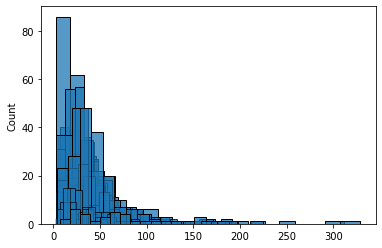

In [18]:
max_length = 0
for index, row in df.iterrows():
    sns.histplot(row['lengths'],bins=15)
    if row['max_length'] > max_length:
        max_length = row['max_length']
        
print(max_length)

### Padding the sentences with PAD token

In [19]:
# MAX_LENGTH = 330
# attention_matrix = np.zeros(train_sents)
for doc_index, doc in enumerate(train_sents):
    MAX_LENGTH = df.iloc[doc_index]['max_length'] + 1
    for sent_index, sentence in enumerate(doc):
        train_sents[doc_index][sent_index] = train_sents[doc_index][sent_index] + [tokenizer.pad_token for _ in range(MAX_LENGTH - len(train_sents[doc_index][sent_index]))]
        # for token in train_sents[doc_index][sent_index]:
        # attention_matrix[doc_index][sent_index] = [1 if token != tokenizer.pad_token else 0 for token in train_sents[doc_index][sent_index]]

### Creating attention matrix for each document

In [20]:
ids = []
segs = []
for doc_index, doc in enumerate(train_sents):
    globals()[f"attention_mask_{doc_index}"] = np.zeros_like(doc,dtype='int')
    sent_id = []
    sent_segs = []
    for sent_index,sentence in enumerate(doc):
        sent_id.append(tokenizer.convert_tokens_to_ids(sentence))
        sent_segs.append([0 for _ in range(len(sentence))])
        for i in range(len(sentence)):
            if sentence[i] != tokenizer.pad_token:
                globals()[f'attention_mask_{doc_index}'][sent_index][i] = 1 
    ids.append(sent_id)
    segs.append(sent_segs)

In [21]:
len(ids)
# len(segs)

30

In [22]:
for i in range(len(train_sents)):
    print(f'Attention Mask for document {i+1} : {globals()[f"attention_mask_{i}"].shape}')

Attention Mask for document 1 : (96, 312)
Attention Mask for document 2 : (139, 177)
Attention Mask for document 3 : (150, 153)
Attention Mask for document 4 : (54, 196)
Attention Mask for document 5 : (86, 153)
Attention Mask for document 6 : (57, 139)
Attention Mask for document 7 : (68, 169)
Attention Mask for document 8 : (113, 112)
Attention Mask for document 9 : (199, 228)
Attention Mask for document 10 : (139, 138)
Attention Mask for document 11 : (76, 140)
Attention Mask for document 12 : (104, 115)
Attention Mask for document 13 : (209, 155)
Attention Mask for document 14 : (135, 106)
Attention Mask for document 15 : (64, 193)
Attention Mask for document 16 : (62, 330)
Attention Mask for document 17 : (98, 177)
Attention Mask for document 18 : (111, 199)
Attention Mask for document 19 : (62, 226)
Attention Mask for document 20 : (130, 260)
Attention Mask for document 21 : (46, 177)
Attention Mask for document 22 : (66, 198)
Attention Mask for document 23 : (77, 97)
Attention M

# Extracting sentence embeddings

In [23]:
model = BertModel.from_pretrained("bert-base-uncased")

In [24]:
for i in range(len(train_sents)):
    globals()[f'ids_tensor_{i}'] = torch.LongTensor(ids[i]).unsqueeze(0)
    globals()[f'attention_mask_{i}'] = torch.from_numpy(globals()[f'attention_mask_{i}']).unsqueeze(0)
    globals()[f'seg_tokens_{i}'] = torch.LongTensor(segs[i]).unsqueeze(0)

In [25]:
type(attention_mask_0)

torch.Tensor

In [26]:
type(ids_tensor_0)

torch.Tensor

In [27]:
type(seg_tokens_0)

torch.Tensor

In [28]:
globals()[f'ids_tensor_{0}'][:,0,:]

tensor([[  101,  9964,  2121,  1024,  1996,  5849,  1997,  3318,  1011,  4171,
          2638,  2860,  6768,  5443,  1012,  6869,  4765,  1024,  1049,  1013,
          1055,  1012, 20979,  2072, 21348,  4231,  3654,  8223,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [109]:
# for doc_index, doc in enumerate(train_sents):
#     last_hidden_state = []
#     pooler_output = []
#     for sent_index in range(len(doc)):
#         # if doc_index == 0:
#             # print(sent_index)
#         output = model(globals()[f'ids_tensor_{doc_index}'][:,sent_index,:],
#                         attention_mask = globals()[f'attention_mask_{doc_index}'][:,sent_index,:],
#                         token_type_ids = globals()[f'seg_tokens_{doc_index}'][:,sent_index,:])
#         last_hidden_state.append(output[0])
#         pooler_output.append(output[1])
#     globals()[f'last_hidden_state_{doc_index}'], globals()[f'pooler_output_{doc_index}'] = last_hidden_state, pooler_output

: 

In [29]:
model(ids_tensor_0[:,0,:],attention_mask_0[:,0,:],seg_tokens_0[:,0,:]).pooler_output.size()

torch.Size([1, 768])

In [38]:
sentence_embeddings = []
for i in range(15):
    emb = model(ids_tensor_0[:,i,:],attention_mask_0[:,i,:],seg_tokens_0[:,i,:]).pooler_output
    sentence_embeddings.append(emb.squeeze(0))

In [40]:
sentence_embeddings[0]

tensor([-0.7982, -0.6213, -0.9930,  0.8219,  0.8735, -0.0638,  0.8326,  0.4112,
        -0.9566, -1.0000, -0.6701,  0.9827,  0.9666,  0.9090,  0.8108, -0.8306,
        -0.4873, -0.6087,  0.4045, -0.0275,  0.6322,  1.0000, -0.2292,  0.3444,
         0.6154,  0.9920, -0.7193,  0.8319,  0.9577,  0.6229, -0.5734,  0.4076,
        -0.9837, -0.2753, -0.9930, -0.9912,  0.4864, -0.5738, -0.0349, -0.0735,
        -0.7977,  0.3975,  1.0000,  0.2181,  0.5813, -0.3075, -1.0000,  0.4228,
        -0.8517,  0.9853,  0.9660,  0.9800,  0.3843,  0.5900,  0.5017, -0.6093,
         0.0979,  0.2046, -0.4065, -0.6323, -0.6516,  0.5478, -0.9574, -0.8865,
         0.9796,  0.9704, -0.3265, -0.5351, -0.2749,  0.0122,  0.8151,  0.3645,
        -0.6354, -0.6827,  0.8945,  0.4332, -0.7547,  1.0000, -0.5801, -0.9594,
         0.9815,  0.9534,  0.7043, -0.8032,  0.8763, -1.0000,  0.7183, -0.1077,
        -0.9846,  0.4159,  0.6755, -0.4850,  0.9392,  0.7123, -0.8239, -0.7286,
        -0.5515, -0.9259, -0.4819, -0.61

 - Create function that given a sentence produces id, attention mask and seg
 - Create a function that uses those 3 as input and produces embeddings on the fly

# Tom's work

In [2]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

import json

file_path = '../data/train.json'

with open(file_path, 'r') as file:
    data = json.load(file)
    
    for key, value in data[0].items():
        
        if key == 'annotations':
            for element in value:
                for key2, value2 in element.items():
                    for element2 in value2:
                        for key3, value3 in element2.items():
                            if isinstance(value3, dict):
                                for key4, value4 in value3.items():
                                    if key4 == "text":
                                        print(value4)
                                        
                                    inputs = tokenizer(key4, return_tensors="pt", truncation=True, padding=True)
                                    outputs = model(**inputs)

                                    bert_embedding = outputs.last_hidden_state[:, 0, :]


                                    bert_embedding_np = bert_embedding.detach().numpy()

                                    
                                    print(bert_embedding_np.shape)

(1, 768)
(1, 768)
      IN THE HIGH COURT OF KARNATAKA,
          CIRCUIT BENCH AT GULBARGA

DATED THIS THE 22ND DAY OF FEBRUARY, 2013
(1, 768)
(1, 768)
(1, 768)
(1, 768)


      BEFORE

THE HON'BLE MR.JUSTICE ANAND BYRAREDDY

      CRIMINAL APPEAL NO.3532 OF 2012

BETWEEN:                                            R

Babu S/o Siddappa,                         .. APPELLANT
Age: 30 Years, Occ: Household,
R/o: Sunthan Village,
Taluk Chincholi,
District Gulbarga.

(By Shri Ishwar Raj S.Chowdapur, Advocate)

AND:

The State of Karnataka                     .. RESPONDENT
(Through Ratkal Police Station)
Represented by Additional State
Public Prosecutor, Circuit Bench,
Gulbarga.

(By Shri S.S.Aspalli, Government Pleader)

       
(1, 768)
(1, 768)
(1, 768)
(1, 768)
This Criminal Appeal is filed under Section 374(2) of the
Code of Criminal Procedure, 1973 by the advocate for the
appellant praying to set aside the order of conviction and

sentence in S.C.No.232/2008 on the file of the II Addit

In [11]:
data[0]

{'id': 1735,
 'annotations': [{'result': [{'id': 'd7a902fe9c23417499a7ef782f9fbdeb',
     'type': 'labels',
     'to_name': 'text',
     'from_name': 'label',
     'value': {'start': 0,
      'end': 116,
      'text': '      IN THE HIGH COURT OF KARNATAKA,\n          CIRCUIT BENCH AT GULBARGA\n\nDATED THIS THE 22ND DAY OF FEBRUARY, 2013',
      'labels': ['PREAMBLE']}},
    {'id': '8d41599e98424d9480c25109556a7d14',
     'type': 'labels',
     'to_name': 'text',
     'from_name': 'label',
     'value': {'start': 116,
      'end': 678,
      'text': "\n\n      BEFORE\n\nTHE HON'BLE MR.JUSTICE ANAND BYRAREDDY\n\n      CRIMINAL APPEAL NO.3532 OF 2012\n\nBETWEEN:                                            R\n\nBabu S/o Siddappa,                         .. APPELLANT\nAge: 30 Years, Occ: Household,\nR/o: Sunthan Village,\nTaluk Chincholi,\nDistrict Gulbarga.\n\n(By Shri Ishwar Raj S.Chowdapur, Advocate)\n\nAND:\n\nThe State of Karnataka                     .. RESPONDENT\n(Through Ratkal Poli